<a href="https://colab.research.google.com/github/sin-of-sloth/mushroom/blob/master/Mushroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom classification using their physical features

## Setting things up



In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## The Dataset

Dataset used is from the UCI Machine Learning Repository, called the [Secondary Mushroom Dataset](https://archive.ics.uci.edu/ml/datasets/Secondary+Mushroom+Dataset). It has 61,069 instances, each having 21 features, like 

### Fetching the data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00615/MushroomDataset.zip
!unzip MushroomDataset.zip

--2023-04-24 01:58:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00615/MushroomDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473175 (462K) [application/x-httpd-php]
Saving to: ‘MushroomDataset.zip’

MushroomDataset.zip 100%[===================>] 462.08K   624KB/s    in 0.7s    

2023-04-24 01:58:43 (624 KB/s) - ‘MushroomDataset.zip’ saved [473175/473175]

Archive:  MushroomDataset.zip
   creating: MushroomDataset/
  inflating: MushroomDataset/primary_data.csv  
  inflating: MushroomDataset/primary_data_meta.txt  
  inflating: MushroomDataset/secondary_data.csv  
  inflating: MushroomDataset/secondary_data_meta.txt  


### Dataset description

In [ ]:
!cat MushroomDataset/secondary_data_meta.txt

1. Title: Secondary mushroom data

2. Sources:
	(a) Mushroom species drawn from source book:
		Patrick Hardin.Mushrooms & Toadstools.
	    Zondervan, 1999
	(b) Inspired by this mushroom data:
		Jeff Schlimmer.Mushroom Data Set. Apr. 1987.
		url:https://archive.ics.uci.edu/ml/datasets/Mushroom.
	(c) Repository containing the related Python scripts and all the data sets: https://mushroom.mathematik.uni-marburg.de/files/ 
	(d) Author: Dennis Wagner
	(e) Date: 05 September 2020

3. Relevant information:
	This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms
	per species). Each mushroom is identified as definitely edible, definitely poisonous, or of 
	unknown edibility and not recommended (the latter class was combined with the poisonous class).
	Of the 20 variables, 17 are nominal and 3 are metrical.

4. Data simulation:
	The related Python project (Sources (c)) contains a Python module secondary_data_generation.py
	used to generate this data base

## Importing required libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, VotingClassifier
from scipy.stats import randint
from numpy import array, argmax
from numpy.core.numeric import tensordot
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('./MushroomDataset/secondary_data.csv', sep=';')
data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [ ]:
data.shape

(61069, 21)

In [ ]:
data.dropna(axis=1, thresh=data.shape[0]/2, inplace=True)
data.shape

(61069, 16)

## Data Preprocessing

### Convert character/text labels to integers

In [ ]:
def encode_labels(dataset):
    le = LabelEncoder()
    enc_features = []
    for feature, datatype in dataset.dtypes.items():
        if datatype == 'object':
            enc_features.append(feature)
            labels = le.fit_transform(dataset[feature])
            dataset.drop(feature, axis=1, inplace=True)
            dataset[feature] = labels
    print(f'encoded {len(enc_features)} features: {enc_features}')
    return dataset

In [ ]:
# encode labels and move `class` to front of the dataframe
data = encode_labels(data)
data.insert(0, 'class', data.pop('class'))

encoded 13 features: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


### Feature Correlations

Text(0.5, 1.0, 'Correlation Matrix')

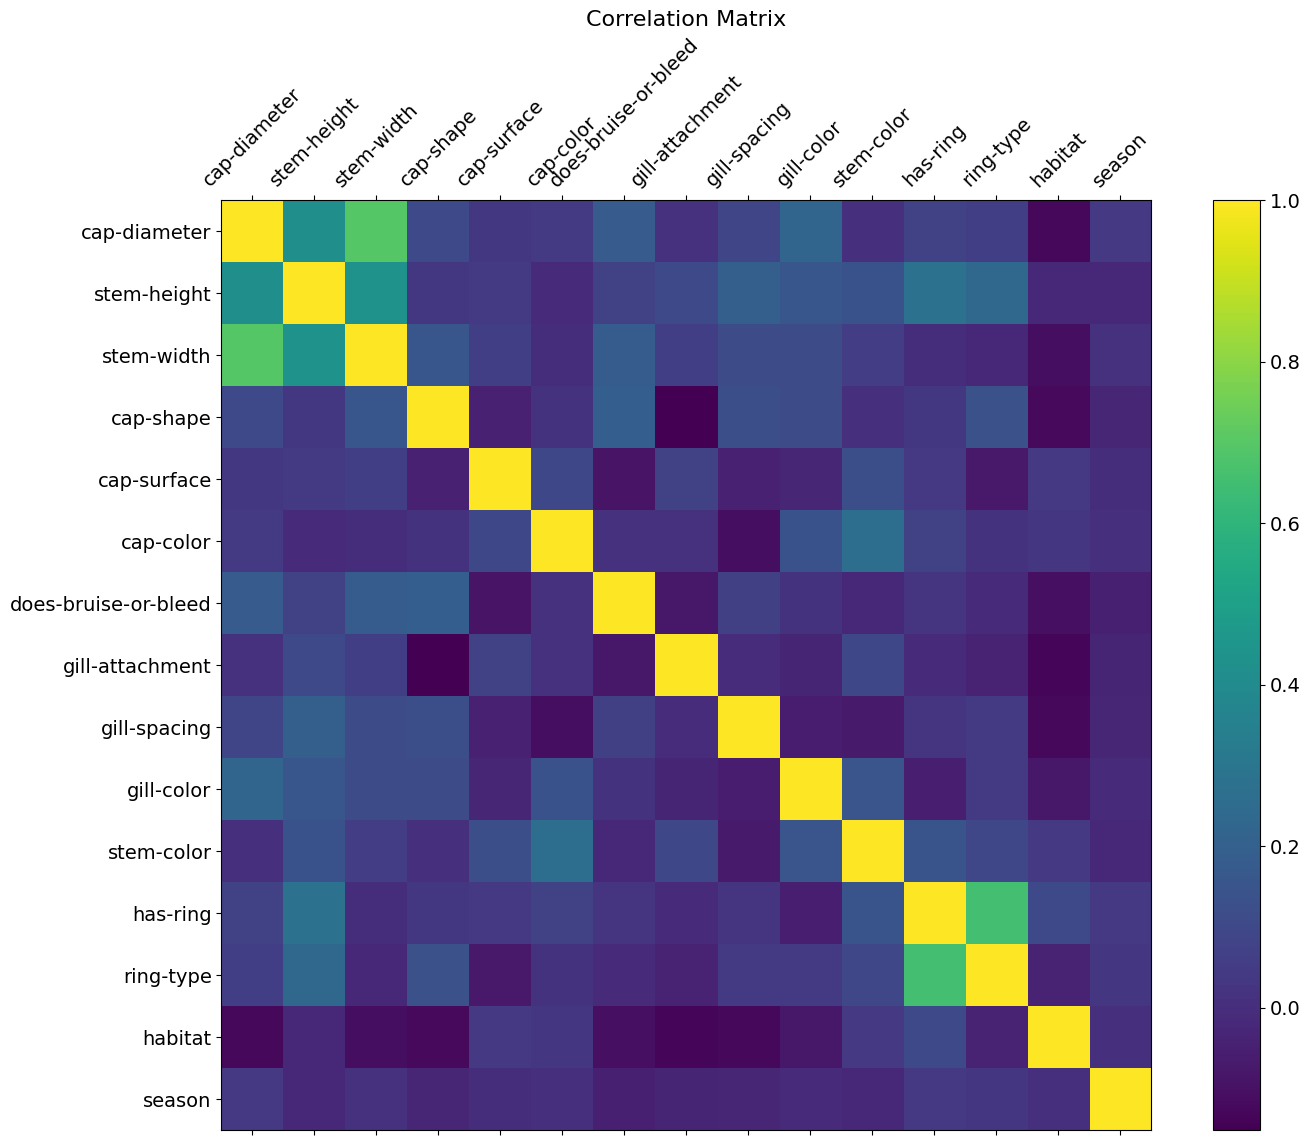

In [ ]:
feature_data = data.iloc[:, 1:]

f = plt.figure(figsize=(16, 12))
plt.matshow(feature_data.corr(), fignum=f.number)
plt.xticks(range(feature_data.select_dtypes(['number']).shape[1]), feature_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(feature_data.select_dtypes(['number']).shape[1]), feature_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## Creating train-test-validation splits

In [ ]:
def train_test_validation_split(x_data, y_data):
    # training split is 70% of total data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=1)
    # divide remaining 30% in half for test and validation splits
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [ ]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(X, y)

In [ ]:
def get_cross_validated_results(
    model_name, model, param_distributions, cv_gen, X_train, y_train, X_test, y_test
):
    clf = RandomizedSearchCV(model, param_distributions, cv=cv_gen)
    clf.fit(X_train, y_train)
    
    print(model_name)
    print(clf.best_params_)
    y_pred = clf.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    return clf.best_estimator_, accuracy

## Experiment 1

- train models on train split
- evaluate on validation split and note their accuracies
- finally, test on test split by taking a weighted average as the final prediction, where each model prediction is weighted by their validation accuracy

Initializing models' array and their weights

In [ ]:
models = []
model_weights = []

### Decision Tree

In [ ]:
dtree = DecisionTreeClassifier()
param_distributions = dict(
    max_depth=randint(5, 10),
    criterion=["gini", "entropy"],
    min_samples_leaf=randint(1, 9)
)

best_model, accuracy = get_cross_validated_results(
    'Decision Tree', dtree, param_distributions, 10, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

Decision Tree
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 6}
Accuracy: 0.9057963104464578


### AdaBoost


In [ ]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))
param_distributions = dict(
    n_estimators=randint(20, 30),
)

best_model, accuracy = get_cross_validated_results(
    'AdaBoost', ada, param_distributions, 5, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

AdaBoost
{'n_estimators': 28}
Accuracy: 0.9718371356838773


### HistGradientBoostingClassifier

In [ ]:
hgb = HistGradientBoostingClassifier()
param_distributions = dict(
    max_depth=randint(3, 6),
    max_iter=randint(20, 50),
    min_samples_leaf=randint(30, 50)
)
best_model, accuracy = get_cross_validated_results(
    'Histogram-based Gradient Boosted Classifier', hgb, param_distributions, 5, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

Histogram-based Gradient Boosted Classifier
{'max_depth': 5, 'max_iter': 32, 'min_samples_leaf': 37}
Accuracy: 0.9537168431393953


### Ensemble

Takes a weighted average of each model's prediction for a final prediction - threshold set at 0.5 for classification

In [ ]:
def ensemble_predictions(models, weights, n_models, X_test, y_test):
    y_preds = [model.predict(X_test) for model in models]
    for i, y_pred in enumerate(y_preds):
        print(f'{models[i]} \t: {accuracy_score(y_test, y_pred)}')
    y_preds = array(y_preds)
    weighted_avg = tensordot(y_preds, weights, axes=((0), (0))) / n_models
    weighted_avg[weighted_avg < 0.5] = 0
    weighted_avg[weighted_avg >= 0.5] = 1
    print(f'ensemble \t: {accuracy_score(y_test, weighted_avg)}')

In [ ]:
y_pred = ensemble_predictions(models, model_weights, len(models), X_test, y_test)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=6) 	: 0.9061135371179039
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=28) 	: 0.9748908296943232
HistGradientBoostingClassifier(max_depth=5, max_iter=32, min_samples_leaf=37) 	: 0.9545851528384279
ensemble 	: 0.970414847161572


## Experiment 2

### Modified Dataset

Assumption is that converting color features to it's component `r`, `g`, and `b` values might be a better discriminant

In [ ]:
data = pd.read_csv('./MushroomDataset/secondary_data.csv', sep=';')

# brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k, none=f
colors = {
    'n': {'r': 165, 'g': 42, 'b': 42, 'a': 1},
    'b': {'r': 218, 'g': 160, 'b': 109, 'a': 1},
    'g': {'r': 128, 'g': 128, 'b': 128, 'a': 1},
    'r': {'r': 0, 'g': 128, 'b': 0, 'a': 1},
    'p': {'r': 255, 'g': 192, 'b': 203, 'a': 1},
    'u': {'r': 128, 'g': 0, 'b': 128, 'a': 1},
    'e': {'r': 255, 'g': 0, 'b': 0, 'a': 1},
    'w': {'r': 255, 'g': 255, 'b': 255, 'a': 1},
    'y': {'r': 255, 'g': 255, 'b': 0, 'a': 1},
    'l': {'r': 0, 'g': 0, 'b': 255, 'a': 1},
    'o': {'r': 255, 'g': 165, 'b': 0, 'a': 1},
    'k': {'r': 0, 'g': 0, 'b': 0, 'a': 1},
    'f': {'r': 0, 'g': 0, 'b': 0, 'a': 0},
}

In [ ]:
mod_data = data.copy()
print(mod_data.shape)
for feature, datatype in data.dtypes.items():
    if 'color' in feature:
        print(f'substituting {feature}')
        color_feature = mod_data.pop(feature)
        color_feature = ['f' if type(val) != type('a') else val for val in color_feature]
        feature_r = [colors[val]['r'] for val in color_feature]
        feature_g = [colors[val]['g'] for val in color_feature]
        feature_b = [colors[val]['b'] for val in color_feature]
        feature_a = [colors[val]['a'] for val in color_feature]

        mod_data[f'{feature}-r'] = feature_r
        mod_data[f'{feature}-g'] = feature_g
        mod_data[f'{feature}-b'] = feature_b
        mod_data[f'{feature}-a'] = feature_a

(61069, 21)
substituting cap-color
substituting gill-color
substituting stem-color
substituting veil-color
substituting spore-print-color


In [ ]:
mod_data.shape

(61069, 36)

Dropping columns that have more than half NaN values

In [ ]:
mod_data.dropna(axis=1, thresh=mod_data.shape[0]/2, inplace=True)
mod_data.shape

(61069, 33)

### Convert character/text labels to integers

In [ ]:
# encode labels and move `class` to front of the dataframe
mod_data = encode_labels(mod_data)
mod_data.insert(0, 'class', mod_data.pop('class'))

encoded 10 features: ['class', 'cap-shape', 'cap-surface', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'has-ring', 'ring-type', 'habitat', 'season']


### Creating train-test-validation splits

In [ ]:
X = mod_data.iloc[:, 1:]
y = mod_data.iloc[:, 0]

X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(X, y)

Initializing models' array and their weights

In [ ]:
models = []
model_weights = []

### Decision Tree

In [ ]:
dtree = DecisionTreeClassifier()
param_distributions = dict(
    max_depth=randint(5, 10),
    criterion=["gini", "entropy"],
    min_samples_leaf=randint(1, 9)
)

best_model, accuracy = get_cross_validated_results(
    'Decision Tree', dtree, param_distributions, 10, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

Decision Tree
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5}
Accuracy: 0.8993559655059491


### AdaBoost

In [ ]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))
param_distributions = dict(
    n_estimators=randint(20, 30),
)

best_model, accuracy = get_cross_validated_results(
    'AdaBoost', ada, param_distributions, 5, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

AdaBoost
{'n_estimators': 29}
Accuracy: 0.9841720336207838


### HistGradientBoostingClassifier

In [ ]:
hgb = HistGradientBoostingClassifier()
param_distributions = dict(
    max_depth=randint(3, 6),
    max_iter=randint(20, 50),
    min_samples_leaf=randint(30, 50)
)
best_model, accuracy = get_cross_validated_results(
    'Histogram-based Gradient Boosted Classifier', hgb, param_distributions, 5, X_train, y_train, X_val, y_val
)

models.append(best_model)
model_weights.append(accuracy)

Histogram-based Gradient Boosted Classifier
{'max_depth': 5, 'max_iter': 38, 'min_samples_leaf': 42}
Accuracy: 0.9765309464032311


### Ensemble

In [ ]:
def ensemble_predictions(models, weights, n_models, X_test, y_test):
    y_preds = [model.predict(X_test) for model in models]
    for i, y_pred in enumerate(y_preds):
        print(f'{models[i]} \t: {accuracy_score(y_test, y_pred)}')
    y_preds = array(y_preds)
    weighted_avg = tensordot(y_preds, weights, axes=((0), (0))) / n_models
    weighted_avg[weighted_avg < 0.5] = 0
    weighted_avg[weighted_avg >= 0.5] = 1
    print(f'ensemble \t: {accuracy_score(y_test, weighted_avg)}')

In [ ]:
y_pred = ensemble_predictions(models, model_weights, len(models), X_test, y_test)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=5) 	: 0.9037117903930131
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=29) 	: 0.9838427947598253
HistGradientBoostingClassifier(max_depth=5, max_iter=38, min_samples_leaf=42) 	: 0.9778384279475982
ensemble 	: 0.9846069868995633
